In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from utils import train_network, test_network
import matplotlib.pyplot as plt
from tqdm import tqdm
from networks import MyNetwork
import cv2
import numpy as np
# import utils

In [14]:
model = MyNetwork()
model.load_state_dict(torch.load('mnist_model.pt'))

# Freeze the parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layer
model.classifier[2].requires_grad = True

print(model)


MyNetwork(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (block_2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=320, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [15]:
class GreekTransform:
    def __call__(self, x):
        x = transforms.functional.rgb_to_grayscale(x)
        x = transforms.functional.affine(x, 0, (0, 0), 36/128, 0)
        x = transforms.functional.center_crop(x, (28, 28))
        return transforms.functional.invert(x)


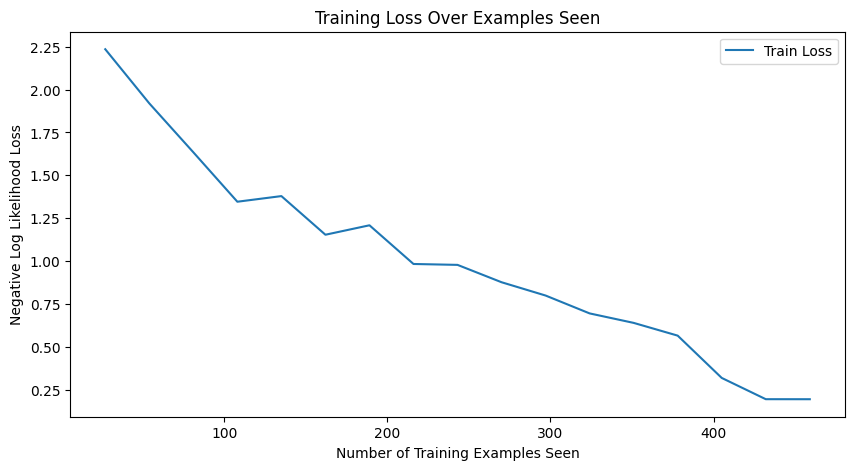

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DataLoader for the Greek dataset
training_set_path = 'data/greek_train'
greek_transform = transforms.Compose([
    transforms.ToTensor(),
    GreekTransform(),  # Make sure GreekTransform is defined as before
    transforms.Normalize((0.1307,), (0.3081,))
])

greek_train_dataset = datasets.ImageFolder(root=training_set_path, transform=greek_transform)
greek_train_loader = torch.utils.data.DataLoader(greek_train_dataset, batch_size=5, shuffle=True)

model = MyNetwork().to(device)
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.5)

# Lists to store loss and accuracy values
train_losses = []
examples_seen = 0

for epoch in range(1, 18):
    avg_train_loss, num_examples = train_network(model, device, greek_train_loader, optimizer, epoch)
    examples_seen += num_examples
    train_losses.append((examples_seen, avg_train_loss))
    
# Save the model after training
torch.save(model.state_dict(), "mnist_greek_model.pt")

# Optionally, plot training losses
plt.figure(figsize=(10, 5))
train_x, train_y = zip(*train_losses)
plt.plot(train_x, train_y, label='Train Loss')
plt.xlabel('Number of Training Examples Seen')
plt.ylabel('Negative Log Likelihood Loss')
plt.legend()
plt.title('Training Loss Over Examples Seen')
plt.show()


In [21]:
def preprocess(image_path):
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.resize(img, (28, 28))  # Resize to match the model's expected input size
    img = np.array(img, dtype=np.float32) / 255.0  # Normalize the image
    img = 1.0 - img  # Invert the image
    img = img.reshape(1, 1, 28, 28)  # Add batch and channel dimensions
    img_tensor = torch.tensor(img)  # Convert to tensor
    return img_tensor

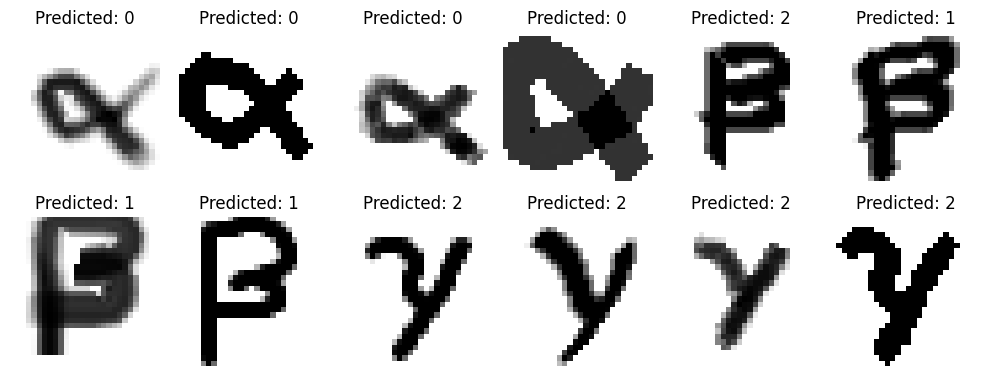

In [22]:
model.eval()
paths = ['a1.png', 'a2.png', 'a3.png', 'a4.png', 'b1.png', 'b2.png','b3.png','b4.png','c1.png','c2.png','c3.png','c4.png']
plt.figure(figsize=(10, 4))
for i, path in enumerate(paths):
    image_path="data\\greek_test\\" + path
    img_tensor = preprocess(image_path)
    with torch.no_grad():
        output = model(img_tensor)
        prediction = output.argmax(dim=1, keepdim=True).item()  # Get the index of the max log-probability

    plt.subplot(2, 6, i+1)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # image = cv2.bitwise_not(image)  # Invert the image to match MNIST
    plt.imshow(image, cmap='gray')
    plt.title(f'Predicted: {prediction}')
    plt.axis('off')
plt.tight_layout()
plt.show()